In [23]:
!pip install yfinance==0.1.52
!pip install dash
!pip install dash_table
!pip install colorlover
!pip install jupyter_dash


In [108]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


# for Conditional Formatting
import dash
import dash_table
import dash_html_components as html
import colorlover
from jupyter_dash import JupyterDash

# Finance data  
def fin_data_points(tickets):    
    '''
    Computes finance data for the given list of assets (tickets)
    '''
   
    #create dataframe
    Fin_Data = pd.DataFrame(columns = ['P/B','P/E','D/E','ROE','ROA','Gross Profit Margin','EBIT Margin',
                                       'Profit Margin','Dividend yeild'], index = tickets) 

    for i in range(len(tickets)):
        name = tickets[i]
        company = yf.Ticker(name)

        inf = company.info
        fin_4 = company.quarterly_financials
        balance = company.balance_sheet
        balance_4 = company.quarterly_balance_sheet

        Assets = balance_4.loc['Total Assets']
        Capitalization = inf['marketCap']
        Equity =  Assets - balance_4.loc['Total Liab']
        NetProfit = inf['netIncomeToCommon']

        PB = Capitalization/abs(Equity)
        PE = Capitalization/NetProfit
        PB_dt_max = PB.index.max()

        DE = balance_4.loc["Total Liab"]/Equity
        DE_dt_max = DE.index.max()
        
        ROE = NetProfit/Equity * 100
        ROA = NetProfit/Assets * 100
        ROE_dt_max = ROE.index.max()
        ROA_dt_max = ROA.index.max()

        #NetIncome_years = fin.loc['Net Income']
        Ebit = fin_4.loc['Ebit']
        Sales = fin_4.loc['Total Revenue']
        GrossProfit = fin_4.loc['Gross Profit']

        GrossProfitMargin = GrossProfit/Sales * 100
        GPM_dt_max = GrossProfitMargin.index.max()
        EbitMargin = Ebit/Sales * 100
        EM_dt_max = EbitMargin.index.max()
        ProfitMargins = inf['profitMargins'] * 100
        
        DivYield = inf["dividendYield"]
        if DivYield is not None:
            DivYield = round(float(DivYield) * 100,4) 

        Fin_Data['P/B'].loc[name] = round(PB.loc[PB_dt_max],4)
        Fin_Data['P/E'].loc[name] = round(PE,4)
        Fin_Data['D/E'].loc[name] = round(DE.loc[DE_dt_max],2)
        Fin_Data['ROE'].loc[name] = round(ROE.loc[ROE_dt_max],4)
        Fin_Data['ROA'].loc[name] = round(ROA.loc[ROA_dt_max],4)
        Fin_Data['Gross Profit Margin'].loc[name] = round(GrossProfitMargin.loc[GPM_dt_max],4)
        Fin_Data['EBIT Margin'].loc[name] = round(EbitMargin.loc[EM_dt_max],4)
        Fin_Data['Profit Margin'].loc[name] = round(ProfitMargins,4)
        Fin_Data['Dividend yeild'].loc[name] = DivYield
        
    return Fin_Data


def highlight_thebest_fin(data, color='green'):
    '''
    highlight the minimum in columns in "P/B","P/E","D/E"
    highlight the maximum in other columns
    '''
    
    min_v = ["P/B","P/E","D/E"]
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        if data.name not in min_v:
            is_max = data == data.max()
            #if data[is_max].index == '':
                #print(data.values)
            return [attr if v else '' for v in is_max]
        else:
            is_min = data == data.min()
            return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index = data.index, columns = data.columns)

# General info  
def info_data(tickets):    
 
    #create dataframe
    INF_Data = pd.DataFrame(columns = ['Industry','sector','country', 'recom'], index = tickets) 

    for i in range(len(tickets)):
        name = tickets[i]
        company = yf.Ticker(name)

        inf = company.info
        recom = company.recommendations
        if recom is not None:
            dt_max = recom.index.max()
            #recom = recom.loc[dt_max]['To Grade'] + ' /' + recom.loc[dt_max]['Firm'] + ' ' + str(dt_max)
            recom = recom.tail(1)['To Grade'].values + ' /' + recom.tail(1)['Firm'].values+ ' ' + str(dt_max)        
        else:
            recom = ''

        INF_Data['Industry'].loc[name] = inf['industry']
        INF_Data['sector'].loc[name] = inf['sector']
        INF_Data['country'].loc[name] = inf['country']
        INF_Data['recom'].loc[name] = recom
        
    return INF_Data

In [106]:
# Prices daily/weekly/ monthly price data from yfninace for the list of assets (as_lt)  - period = n_years
def yfin_dprices(lt, n_years = 5):
    from dateutil.relativedelta import relativedelta
    import datetime
    dt = datetime.date.today()    
    dt_minus_nyears = (dt - relativedelta(years=n_years)).strftime('%Y-%m-%d')
    dt = dt.strftime('%Y-%m-%d')

    prices = pd.DataFrame(columns=lt)

    for l in lt:
        prices[l] = yf.download(l,dt_minus_nyears,dt)['Adj Close']        
    return prices


def yfin_wkprices(lt, n_years = 5 ): 
    return yfin_dprices(lt, n_years).resample('W').apply(lambda x: x[-1])


def yfin_mprices(lt, n_years = 5 ):
    return yfin_dprices(lt, n_years).resample('BM').apply(lambda x: x[-1])

# Returns daily/weekly/ monthly price data from yfninace for the list of assets (as_lt)

def yfin_dreturns(lt, n_years = 5):
    prices_daily = yfin_dprices(lt, n_years)
    returns_daily= prices_daily.pct_change()
    returns_daily = returns_daily.dropna() #delete Na   
    return returns_daily

def yfin_wkreturns(lt, n_years = 5 ):
    prices_weekly = yfin_wkprices(lt,n_years)
    returns_weekly = prices_weekly.pct_change()
    
    returns_weekly = returns_weekly.dropna() #delete Na
    #returns_daily = returns_daily.fillna(0, inplace=True)
    return returns_weekly 

def yfin_mreturns(lt, n_years = 5):
    prices_monthly = yfin_mprices(lt, n_years)
    returns_monthly = prices_monthly.pct_change()
    returns_monthly = returns_monthly.dropna() #delete Na
    
    returns_monthly.index = pd.to_datetime(returns_monthly.index, format="%Y%m").to_period('M')   
    return returns_monthly
    
    
# Risk Functions - annualizing returns, volatility (std dev), sharpe ratio coef, max drawdown
def annualize_rets(r, periods_per_year = 12):
    compounded_growth = (1 + r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods) - 1 #return (x+1)**Freq-1

def annualize_vol(r, periods_per_year = 12):
    return r.std()*(periods_per_year**0.5) #x*np.sqrt(Freq)

def RiskFree_wk(n_years):
    """
    take 13 Week Treasury Bill  as a risk-free rate - to calculate Sharpe ratio
    ^IRX from yfinance
    """
    TBill_wk = yfin_wkreturns(lt = ["^IRX"],n_years = n_years)

    RiskFree_df = pd.DataFrame(columns = ['RET'], index = TBill_wk.index) 
    RiskFree_df['RET'] = (TBill_wk['^IRX'].values/100 + 1) ** (1 / 52) - 1 #weekly frequency = 52 per year


    RiskFree_df_weekly = (RiskFree_df['RET'] + 1).resample('W').prod() - 1 # to the same weekly frequency = 52 
    TBill_wk = pd.DataFrame(columns = ['T-Bill'], index = RiskFree_df_weekly.index)  #create a new dataframe 
    TBill_wk['T-Bill'] = RiskFree_df_weekly

    #ind = (TBill.index >= RiskFree_df_weekly.index[[0]][0])*(TBill.index <= RiskFree_df_weekly.index[[-1]][0])
    #TBill = TBill[ind] #keep the same start and end date as the stock returns data    
    return TBill_wk

def ann_sharpe_ratio(r, riskfree_rate, periods_per_year = 52): 
    n = len(r)
    ret_expected = np.sum(r - riskfree_rate)/n
    ret_avg = np.sum(r)/n
    std_dev = np.sqrt( np.sum( (r - ret_avg)**2 ) / n )
    ann_ret_expected = (ret_expected + 1)**periods_per_year - 1
    ann_std_dev = std_dev * np.sqrt(periods_per_year)
    return ann_ret_expected/ann_std_dev


def max_drawd(r):
    wealth = (r + 1).cumprod()
    cummax = wealth.cummax() 
    drawdown = wealth/cummax - 1 
    return drawdown.min()

In [109]:
lt = ["MSFT","GM","BMW.DE","AAPL","NFLX","IBM"]
Fin_Data = fin_data_points(lt)

In [110]:
#display finance data and highlight the best on each finance parameter
Fin_Data.style.apply(highlight_thebest)

,P/B,P/E,D/E,ROE,ROA,Gross Profit Margin,EBIT Margin,Profit Margin,Dividend yeild
MSFT,14.526700,34.882000,1.300000,41.645300,18.134900,68.721500,40.876600,35.016000,0.860000
GM,1.565700,9.496600,3.380000,16.487000,3.764900,15.809600,11.744800,7.489000,None
BMW.DE,0.902200,9.798600,2.420000,9.207500,2.692900,18.272500,11.371300,5.884000,2.040000
AAPL,31.470500,28.528800,3.870000,110.311100,22.633600,42.506500,30.700800,23.451000,0.680000
NFLX,17.233900,59.069000,2.110000,29.175900,9.368800,45.995300,27.359700,14.243000,None
IBM,5.944400,24.215300,5.910000,24.547900,3.553100,46.291400,8.015100,7.278000,4.580000


In [111]:
#display general info
print(info_data(lt))

                               Industry                  sector  \
MSFT            Software—Infrastructure              Technology   
GM                   Auto Manufacturers       Consumer Cyclical   
BMW.DE               Auto Manufacturers       Consumer Cyclical   
AAPL               Consumer Electronics              Technology   
NFLX                      Entertainment  Communication Services   
IBM     Information Technology Services              Technology   

              country                                              recom  
MSFT    United States   [Outperform /KGI Securities 2021-06-02 12:20:01]  
GM      United States         [Overweight /Barclays 2021-06-07 10:56:31]  
BMW.DE        Germany       [Equal-Weight /Barclays 2021-03-12 00:00:00]  
AAPL    United States       [Neutral /Goldman Sachs 2021-04-29 00:00:00]  
NFLX    United States                  [Buy /Stifel 2021-04-21 00:00:00]  
IBM     United States  [Equal-Weight /Morgan Stanley 2021-04-20 00:00...  


In [54]:
period = 10

pricies_daily = yfin_dprices(lt, period)
returns_daily = yfin_dreturns(lt,period)

df = pricies_daily

# Display a brief summary of the dataset 
price_stat = pricies_daily.describe().T
display(price_stat)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,count,mean,std,min,25%,50%,75%,max
MSFT,2517.0,78.925601,63.201816,19.336727,31.725271,50.427040,105.709496,261.366486
GM,2517.0,29.525256,8.653123,14.382098,24.690001,28.356531,34.263557,63.919998
BMW.DE,2468.0,60.670976,11.804252,29.989340,53.089395,61.887064,68.711075,95.889999
AAPL,2517.0,39.857021,31.221788,9.683738,18.607071,27.529018,46.434544,142.704010
NFLX,2517.0,181.312204,163.587486,7.685714,47.774284,108.379997,323.309998,586.340027
IBM,2517.0,127.897248,11.562123,88.795891,120.694763,127.614388,136.653809,155.080948


In [59]:
# Recheck data
print(df.isnull().values.any())

True


In [77]:
df.count()

MSFT      2517
GM        2517
BMW.DE    2468
AAPL      2517
NFLX      2517
IBM       2517
dtype: int64

In [84]:
#display % of None data
df.isnull().sum()/df.count()*100

MSFT      0.000000
GM        0.000000
BMW.DE    1.985413
AAPL      0.000000
NFLX      0.000000
IBM       0.000000
dtype: float64

In [75]:
df.groupby('Date').mean()

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
Date,,,,,,
2011-06-20,19.608082,22.582949,42.547050,9.683738,35.090000,115.170074
2011-06-21,19.840467,22.636501,43.179592,9.990235,36.235714,116.007545
2011-06-22,19.752317,22.927202,43.539143,9.907620,35.522858,115.630707
2011-06-23,19.736290,23.057253,43.419292,10.172345,36.531429,115.937767
2011-06-24,19.471865,22.888947,44.697701,10.022476,36.708572,115.204948
...,...,...,...,...,...,...
2021-06-14,259.890015,60.790001,94.790001,130.479996,499.890015,150.029999
2021-06-15,258.359985,60.810001,94.410004,129.639999,491.899994,149.360001
2021-06-16,257.380005,61.759998,92.980003,130.149994,492.410004,147.830002


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


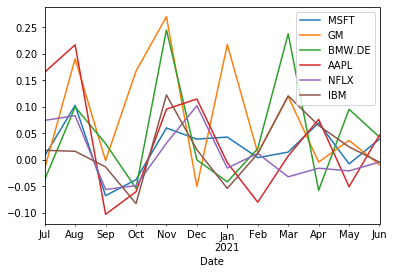

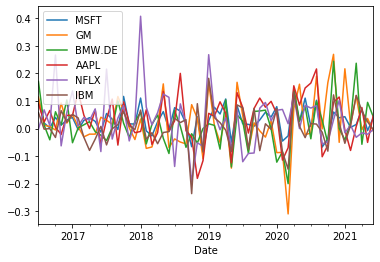

In [85]:
# Monthly return for the last year and for the last 5 years
returns_monthly= yfin_mreturns(lt,period)
returns_monthly.tail(12).plot()
returns_monthly.tail(12 *5).plot()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


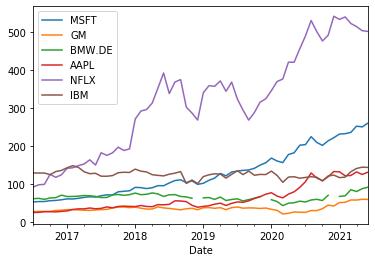

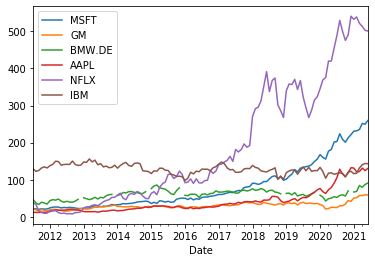

In [86]:
# Monthly prices for the last 5 and 10 year
pricies_monthly = yfin_mprices(lt,10)
pricies_monthly.tail(12 * 5).plot()
pricies_monthly.tail(12 * 10).plot()

In [163]:

#summary statistic

returns_weekly = yfin_wkreturns(lt,period)
TBill_wk = RiskFree_wk(period)

data = returns_weekly
SumStat = pd.DataFrame(index = data.columns)

SumStat['Annualize Returns(,%)'] = np.round( annualize_rets(data,52)*100, 2)
SumStat['Annualize Volatility(,%)'] = np.round( annualize_vol(data,52)*100, 2)
SumStat['Annual Sharpe Ratio'] = np.round(data.apply(ann_sharpe_ratio, riskfree_rate = TBill_wk['T-Bill'], periods_per_year = 52), 2)
SumStat['Max Drawdown(%)'] = np.round(data.apply(max_drawd)*100, 2)

max_rt = SumStat['Annualize Returns(,%)'].max()
pr_rt = max_rt * 0.8
SumStat['Rating Returns'] = SumStat['Annualize Returns(,%)'].apply(lambda x:
  '⭐⭐⭐' if x == max_rt else (   
   '⭐⭐' if x > pr_rt else (
  '⭐' if x > 0 else ''  #the first place
)))

SumStat['SR rating'] = SumStat['Annual Sharpe Ratio'].apply(lambda x: '🔥' if x == SumStat['Annual Sharpe Ratio'].max() else '')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [164]:
# Display summary statistic
SumStat.sort_values('Annual Sharpe Ratio')

,"Annualize Returns(,%)","Annualize Volatility(,%)",Annual Sharpe Ratio,Max Drawdown(%),Rating Returns,SR rating
IBM,2.01,22.84,0.20,-43.12,⭐,
BMW.DE,7.35,29.38,0.41,-57.62,⭐,
GM,9.75,34.95,0.47,-56.44,⭐,
NFLX,29.80,54.23,0.90,-81.73,⭐⭐⭐,
AAPL,29.19,28.05,1.22,-43.64,⭐⭐,
MSFT,29.49,22.63,1.44,-25.69,⭐⭐,🔥


In [165]:
# Todays prices from the max price for the last 10 years ( in %)
df = pricies_daily
df.tail(1)/price_stat['max']*100

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
Date,,,,,,
2021-06-18,99.259089,91.927409,94.848261,91.420001,85.406073,92.287284


In [166]:
# Todays prices
df.tail(1)

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
Date,,,,,,
2021-06-18,259.429993,58.759998,90.949997,130.460007,500.769989,143.119995


##### import yahoo_fin.stock_info as si
msft_data = si.get_quote_table("MSFT")